# Stochastic model
<hr>
## Import necessary modules

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatch
from matplotlib.collections import PatchCollection
from matplotlib import cm
import pandas as pd
from IPython.core.display import HTML
import numpy as np
import scipy as sp
from scipy import stats
import random

Plot figures inline with code and render them as good-looking SVGs:

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

<hr>
## Setting up the model

The parameters of the stochastic model include the equilibrium dipole moment at which the drift term vanishes, $<\! x\! >$; the inverse time scale for slow adjustments to fluctuations in the dipole field, $\gamma$; and the diffusion (noise) term of the stochastic process, $D$. While we can parameterize a stochastic realization with a predetermined equilibrium dipole moment and the distribution of these dipole moments ($<\! x\! >$ and $\sigma^2_x$, respectively), we cannot directly extract these values back out from the model output. Instead—as we must do with actual paleointensity data sets—we assume that the *observed* mean and variance of the dipole moment (here referred to as $\bar{x}$ and $\bar{\sigma^2_x}$, respectively) are good approximations of these values and, by extension, $\gamma$ and $D$.

For the following stochastic realizations, we use the equilibrium dipole moment estimated by Buffett et al. (2013) for the PADM2M model of paleointensity variations over the past 2 million years *(Ziegler et al., 2011)*.

$$\bar{x}\,\approx\,<\! x\! >=5.3\times10^{22}\,\text{A}\,\text{m}^2$$

By combining the power spectra of PADM2M and the higher resolution CALS10k model spanning the past 10,000 years *(Constable et al., 2016)*, and then integrating these data with results from geodynamo models, Buffett and Puranam (2017) updated their estimates for the following stochastic parameters: $\gamma=75\ \text{Myr}^{-1}$ and $D=340\times10^{44}\ \text{A}^2\ \text{m}^4\ \text{Myr}^{-1}$. Assuming these values, we expect that

$$\bar{\sigma_x}\,\approx\,\sigma_x=\sqrt{\small{\frac{D}{\gamma}}}=\sqrt{\small{\frac{340\text{e}44}{75}}}=2.12\times10^{22}\,\text{A}\,\text{m}^2$$

### Drift term
***TODO Discussion of original model; original Kramers' formula; what Kramers' formula actually represents (text below)***
#### The linear model
#### The quadratic approximation *(Buffett et al., 2013)*
#### Other options for drift term: finding best-fit for $D$ and $\gamma$

Given the conditions

${(i) \quad v(<\! x\! >)=0}$

${(ii) \quad v^\prime(<\! x\! >)=-\gamma}$

${(iii) \quad v^\prime(0)=\gamma}$

${(iv) \quad v^{\prime \prime}(<\! x\! >)=0}$

the solution for the drift term is

$$v(x)=\gamma x\Big[1-\frac{13}{8}\Big(\frac{x}{<\! x\! >}\Big)^2 + \frac{3}{4}\Big(\frac{x}{<\! x\! >}\Big)^4 -\frac{1}{8}\Big(\frac{x}{<\! x\! >}\Big)^6\Big].$$

At $x \gg{<\! x\! >}$, higher order terms can cause this drift model to deviate greatly from the approximation of the linear drift model. Thus, it may be reasonable to let $v = -\gamma (x - <\! x\! >)$ when $x \gt{<\! x\! >}$, although this is not essential.

By Kramers' formula, the reversal rate is still

$$r=\frac{\gamma}{2\pi}e^{-\Delta U/D}$$

but $\Delta U$ is different for the polynomial drift function $v(x)$, such that

$$\Delta U=\frac{13}{64}\gamma <\! x\!>^2$$

$$\sigma^2_x = \frac{D}{\gamma}$$

The reversal rate is therefore

$$r=\frac{\gamma}{2\pi}e^{-\frac{13}{64}{<x>^2}/{\sigma^2_x}}$$

Given $<\! x\! >=5.3\times 10^{22}$ and $\sigma_x=2.12\times 10^{22}$ as calculated above, this yields a reversal rate of $r\approx3.4\:\text{Myr}^{-1}$.

<hr>
## Implementing the model

Below, we import a set of functions we will use for running the stochastic realizations and analyzing their output. These functions live in the python module `main_fncs` within the same repository as this notebook.

In [3]:
import main_fncs as mf

Below we inspect the contents of `main_fncs` (imported above as `mf`) to get a list of the imported functions.

In [4]:
print( [nm for nm in dir(mf) if str(nm).startswith('__')==False] )

['count_reversals', 'd', 'np', 'reversal_rate', 'run_realization', 'running_mean', 'v', 'v_lin']


To learn about what it does, we can view the docstring of any of these functions by running
```python
print(mf.<name of function>.__doc__)
```
Within a Jupyter notebook environment, you can also get this information (and more) by running
```ipython
mvf.<name of function>??
```
For example:

In [5]:
mf.count_reversals??

Signature: mf.count_reversals(data)
Source:   
def count_reversals(data):
    """
    function for counting the number of reversals
    (number of times x-axis is crossed, or the dipole
    moment is zero, during a stochastic realization

    Parameters
    ----------
    data : TODO

    Returns
    -------
    TODO

    """
    reversal_count = 0
    for i in range(len(data)-1):
        if data[i]<0 and data[i+1]>0:
            reversal_count += 1
        elif data[i]>0 and data[i+1]<0:
            reversal_count += 1
    return reversal_count
File:      ~/GitHub_files/Stochastic_reversal_rates/code/main_fncs.py
Type:      function


<hr>
## Running the realization

In [6]:
myr = 200 # millions of years
tau = 3e-4 # time interval of realization (in millions of years)

time, vadm = mf.run_realization(myr,5.3e22,tau)

# store the 'full res[olution]' output of the realization in a dataframe
sim_fullres = pd.DataFrame(data={'time':time, 'VDM':vadm})

# take 30 kyr running mean (about the average time resolution of seafloor magnetic anomalies)
time_30k_avg, vadm_30k_avg = mf.running_mean([time, vadm], int(3e-2/tau))
sim_avg = pd.DataFrame(data={'time':time_30k_avg, 'VDM':vadm_30k_avg})
# take 20 kyr running mean for comparison
time_20k_avg, vadm_20k_avg = mf.running_mean([time, vadm], int(2e-2/tau))
sim_avg_20k = pd.DataFrame(data={'time':time_20k_avg, 'VDM':vadm_20k_avg})
# take 10 kyr running mean for comparison
time_15k_avg, vadm_15k_avg = mf.running_mean([time, vadm], int(1.5e-2/tau))
sim_avg_15k = pd.DataFrame(data={'time':time_15k_avg, 'VDM':vadm_15k_avg})

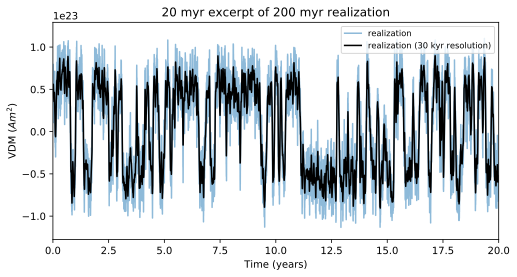

Number of samples = 200

Sampled mean: 5.00E+22
Actual mean: 4.93E+22

Sampled variance: 4.35E+44, standard deviation: 2.09E+22
Actual variance: 5.06E+44, standard deviation: 2.09E+22

Actual reversal rate (30kyr res): 3.60
Actual reversal rate (20kyr res): 4.30
Predicted reversal rate: 3.72



In [7]:
plt.figure(figsize=(8,4))
plt.plot(np.array(time), np.array(vadm), alpha=0.5, label='realization')
plt.plot(time_30k_avg, vadm_30k_avg, c='k', label='realization (30 kyr resolution)')
plt.gca().yaxis.get_major_formatter().set_powerlimits((0,1))
plt.xlabel('Time (years)')
plt.ylabel('VDM $(A m^2)$')
plt.legend(loc=1, fontsize='small')
plt.xlim(0,20)
plt.title('20 myr excerpt of 200 myr realization')
plt.show()

# Here we randomly pull <sample_size> samples from the full resolution realization
# to simulate dipole moment estimates from absolute paleointensity data (the PINT database).
sample_size = 200
random_samples = sim_fullres.loc[np.random.randint(0, len(sim_fullres), size=sample_size)].copy()
random_samples.sort_values(by='time', inplace=True)
random_samples.reset_index(drop=True, inplace=True)

# calculate the observed reversal rate of the time-averaged realizations
act_reversal_rate = mf.count_reversals(sim_avg.VDM.tolist())/float(myr)
act_reversal_rate_20k = mf.count_reversals(sim_avg_20k.VDM.tolist())/float(myr)
act_reversal_rate_15k = mf.count_reversals(sim_avg_15k.VDM.tolist())/float(myr)

# use Kramers' formula to calculate the predicted reversal rate using the mean
# and the variance of samples
rev_rate_predicted = mf.reversal_rate(np.var(np.abs(random_samples.VDM.values)), 
                                   np.mean(np.abs(random_samples.VDM.values)))

# uncomment the block of code below to plot the full realization along with the sample points
"""
plt.figure(figsize=(8,4))
plt.plot(sim_avg.time.values, sim_avg.VDM.values,zorder=0, label='realization (30 kyr resolution)')
plt.plot(sim_fullres.time.values, np.abs(sim_fullres.VDM.values), alpha=0.3, zorder=-1, label='realization')
plt.scatter(random_samples.time.values, np.abs(random_samples.VDM.values), c='k',s=5, zorder=1, label='samples')
plt.ylabel('VDM')
plt.xlabel('time (years)')
plt.xlim(0,myr)
plt.legend(fontsize='small')
plt.show()
"""

print('Number of samples = {0}\n'.format(sample_size))
print('Sampled mean: {0:.2E}'.format(np.mean(np.abs(random_samples.VDM.values))))
print('Actual mean: {0:.2E}\n'.format(np.mean(np.abs(sim_fullres.VDM.values))))
print('Sampled variance: {0:.2E}, standard deviation: {1:.2E}'.format((np.var(np.abs(random_samples.VDM.values))), 
                                                                      (np.std(np.abs(random_samples.VDM.values)))))
print('Actual variance: {0:.2E}, standard deviation: {1:.2E}\n'.format(np.var(np.abs(sim_fullres.VDM.values)),
                                                                      (np.std(np.abs(random_samples.VDM.values)))))
print('Actual reversal rate (30kyr res): {0:.2f}'.format(act_reversal_rate))
print('Actual reversal rate (20kyr res): {0:.2f}'.format(act_reversal_rate_20k))
print('Predicted reversal rate: {0:.2f}\n'.format(rev_rate_predicted))

As we calculated above, our prescribed estimates for $\gamma$, $D$, and $v(x)$ should give us

$$\sigma_x\,\approx\sqrt{\small{\frac{340\text{e}44}{75}}}=2.12\,\small{\times 10^{22}}$$

$$\overline{x}\,\approx\,<\! x\! >=5.3\,\small{\times 10^{22}}$$

with a reversal rate of approximately $3.4\:\text{Myr}^{-1}$.

The 200 myr stochastic realization yields

$$\sigma_x=2.3\,\small{\times 10^{22}}\qquad\sigma_{x\:\text{(sampled)}}=2.3\,\small{\times 10^{22}}$$

$$\overline{x}=5.0\,\small{\times 10^{22}}\qquad\overline{x}_{\text{(sampled)}}=5.2\,\small{\times 10^{22}}$$

with an observed reversal rate of $\sim\!3.5\:\text{Myr}^{-1}$ and a predicted reversal rate of $\sim\!4.1\:\text{Myr}^{-1}$. These values agree quite well.

<hr>
## Quantifying uncertainties for Kramers' formula
In reality, we do not have such high-resolution records of geomagnetic field behavior over million-year timescales. If we are to apply any of the above analyses to paleointensity records, we need to robustly quantify the dependence of the reversal rate function, $r\, (\, \overline{x},\,\sigma_x)$, on the number $N$ of dipole moment estimates used to determine the input values $\overline{x}$ and $\sigma_x$.

Below we use Monte Carlo sampling methods to evaluate this relationship. We iterate over a range of sample numbers (`sample_num`) to which our resampling of the stochastic realization (and thus our calculation of $r$) is restricted. For each value in `sample_num`, we repeat this randomized resampling process to arrive at a representative distribution of $r$ results.

In [8]:
"""
The tqdm module (not required!) provides a load bar for executed cells.
This is helpful for tracking progress of the Monte Carlo 
simulation below, which takes a while to run. 
"""
try:
    from tqdm import tqdm,trange
except:
    def tqdm(z, **kwargs):
        return z

***WARNING: The cell below takes a long time to complete***

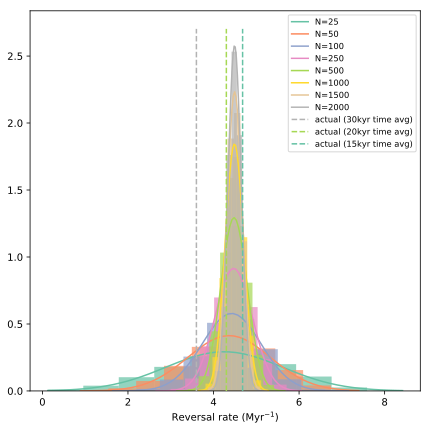

In [9]:
plt.figure(figsize=(7,7))
sample_num = [10, 25, 50, 100, 250, 500, 1000, 1500, 2000]
rev_rate_list, calc_mean_list, calc_var_list, std_dev, mean_hist, var_hist = [], [], [], [], [], []
clr_scale = list(np.linspace(0,1,len(sample_num[1:])))
cmap = cm.get_cmap('Set2') # define colormap

for s in tqdm(sample_num, leave=False):
    rev_rates_mc = []
    for i in range(20000):
        # collect s number of random samples from full resolution realization
        rand_samples = sim_fullres.loc[random.sample(range(len(sim_fullres)), s)]
        rand_samples.reset_index(drop=True, inplace=True)
        # calculate the mean and variance of the population
        full_mean = np.mean(np.abs(rand_samples.VDM.values))
        full_var = np.var(np.abs(rand_samples.VDM.values))
        # record the reversal rate calculation, r
        rev_rates_mc.append(np.mean(mf.reversal_rate(full_var, full_mean)))
    x = np.linspace(min(rev_rates_mc),max(rev_rates_mc)) # span of r
    mu = np.mean(rev_rates_mc) # mean of r
    sigma = np.std(rev_rates_mc) # standard deviation of r
    rev_rate_list.append(mu)
    std_dev.append(sigma)
    if s in sample_num[1:]:
        new_clr=cmap(clr_scale.pop(0))
        plt.hist(rev_rates_mc, density=True,color=new_clr,alpha=0.7)
        plt.plot(x,stats.norm.pdf(x, mu, sigma), color=new_clr, label='N='+str(s))
ylimits = plt.gca().get_ylim()
plt.vlines([act_reversal_rate], ylimits[0], ylimits[1], colors=cmap(1.), 
           linestyles='dashed', label='actual (30kyr time avg)', zorder=10)
plt.vlines([act_reversal_rate_20k], ylimits[0], ylimits[1], colors=cmap(0.5), 
           linestyles='dashed', label='actual (20kyr time avg)', zorder=10)
plt.vlines([act_reversal_rate_15k], ylimits[0], ylimits[1], colors=cmap(0.), 
           linestyles='dashed', label='actual (15kyr time avg)', zorder=10)
plt.legend(fontsize='small')
plt.xlabel('Reversal rate (Myr$^{-1}$)')
plt.show()

actual_mean = np.mean(np.abs(sim_fullres.VDM.values))
actual_var = np.var(np.abs(sim_fullres.VDM.values))

***TODO Brief discussion about the offset between the actual and predicted reversal rates (although these values are quite reasonable, especially with the observation that the predictions are entirely consistent with a reversal rate record averaged to a resolution of 20 kyr instead of 30 kyr). Could be good to calculate the actual confidence bounds of the plot above...at what N do the predictions become "over-confident", such that the actual rates lie outside the 95% confidence interval?***

***Potential additional side investigation with a plot similar to the one above...at what N does the distribution transition from uniform to normal?***

With the output of the Monte Carlo simulation above, we can now associate sample quantities $N$ with characteristic distributions (i.e. standard deviations) of reversal rate predictions $r$. We expect that this relationship will resemble the standard error of a population such that

$$\sigma_r \propto \frac{1}{\sqrt{N}}\;.$$

We then define a model function `std_dev_func` and optimize its coefficients with the `scipy` module `optimize`. We take the resultant function to be a good estimate of the uncertainties in the reversal rate calculations at variable $N$. The formula given in the plot below will be used heavily in the following notebooks as we attempt to apply some of these methods to actual paleointensity estimates of the PINT database.

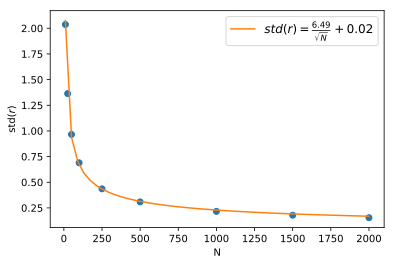

In [10]:
def std_dev_func(x, a, c):
    return a/(x**0.5) + c

popt, pcov = sp.optimize.curve_fit(std_dev_func, np.array(sample_num), np.array(std_dev))
samps = np.linspace(min(sample_num), max(sample_num))
plt.plot(np.array(sample_num), np.array(std_dev), 'C0o')
plt.plot(samps, std_dev_func(samps, *popt), c='C1', label=r'$std(r)=\frac{{{0:.2f}}}{{\sqrt{{N}}}}+{{{1:.2f}}}$'.format(popt[0], popt[1]))
plt.ylabel('std($r$)')
plt.xlabel('N')
plt.legend(fontsize='large')
plt.show()

The values of `popt` defining the standard deviation formula above will be different with every execution of this notebook, since the Monte Carlo simulation will be slightly different each time. The first value (the numerator of the first term) can vary between 6.40 and 6.52, and the second term varies between 0.02 and 0.03. We take the average of these two values in our final definition below, which will be used in future reversal rate calculations.


$$\sigma_r=\frac{6.46}{\sqrt{N}}+0.025\; \text{Myr}^{-1}$$